## Machine Learning & AI

![Colegio Bourbaki](./Images/Bourbaki.png)

### Deep Reinforcement Learning

Este proyecto aprovecha un modelo de aprendizaje profundo de IA para optimizar y reducir el consumo energético de un centro de datos hasta en un 70%. El modelo de IA utiliza el algoritmo Q-Learning para determinar la mejor acción en cada paso temporal. Q-Learning se basa en las ecuaciones de Bellman, que son la base del aprendizaje por refuerzo.

El proyecto pretende reducir el consumo energético de una instalación industrial. Se utiliza un modelo de optimización de aprendizaje profundo y se compara con el sistema de refrigeración integrado tradicional. El enfoque se inspira en la reducción del 40% lograda en los centros de datos de Google utilizando el modelo de IA de DeepMind. El proyecto forma parte del módulo Artificial Intelligence for Business de Udemy.

**En este escenario, hay dos supuestos clave:**

* La temperatura intrínseca de un servidor es una función de la temperatura atmosférica, el número de usuarios en el servidor y la velocidad de transmisión de datos. La relación se aproxima mediante una combinación lineal de esas 3 variables. Los coeficientes se estiman mediante un análisis de regresión.

* La energía gastada para regular la temperatura entre dos pasos temporales es proporcional al cambio absoluto de temperatura. Utilizando esta relación lineal, podemos estimar que el consumo de energía de cada mecanismo es proporcional al cambio absoluto de temperatura del servidor. Esto se aplica tanto al sistema de IA como al sistema de refrigeración integrado tradicional.

Q-Learning es un algoritmo de aprendizaje por refuerzo para aprender la calidad de las acciones que indica a un agente qué acción debe realizar en qué circunstancias. Determina el valor de todas las acciones posibles dado un determinado estado (o circunstancias). No requiere un modelo del entorno, ya que lo aprende mientras lo explora. Los valores de las acciones (o Calidad de las acciones) se determinan recursivamente a medida que el algoritmo explora el entorno y aprende de los resultados obtenidos a lo largo de un elevado número de iteraciones. El aprendizaje Q encuentra una política óptima (secuencia de acciones) que maximiza el valor esperado de la recompensa total en todos y cada uno de los pasos sucesivos, partiendo del estado actual. En otras palabras, el aprendizaje Q puede identificar una política óptima de selección de acciones para cualquier proceso de decisión de Markov finito (no depende del pasado, sino únicamente de las acciones futuras), dado un tiempo de exploración infinito y una política parcialmente aleatoria.

Así, la ecuación de Bellman descompone el valor en dos partes, la recompensa inmediata más los valores futuros descontados. La ecuación de Bellman aparece por todas partes en la literatura del Aprendizaje por Refuerzo, siendo uno de los elementos centrales de muchos algoritmos de Aprendizaje por Refuerzo.

En este proyecto, la recompensa se define como la diferencia absoluta entre la energía requerida por el sistema de refrigeración y la energía requerida por el modelo de IA. Esta es la energía ahorrada por la IA.

El proyecto utiliza una red neuronal sencilla formada por 3 capas totalmente conectadas. La red toma como entrada un vector normalizado que representa el estado. En este problema, el estado está representado por la temperatura del servidor, el número de usuarios y la velocidad de transmisión de datos. El estado se actualiza en cada paso temporal.

Las dos capas ocultas tienen 64 y 32 nodos respectivamente.

La capa de salida predice los valores Q para 5 acciones potenciales que cubren las opciones disponibles para el sistema. Una función de activación softmax genera una distribución de probabilidad sobre las acciones. La probabilidad más alta corresponde al valor Q más alto.

La fase de aprendizaje utiliza la técnica "Experience Replay" para entrenar.

### Librerías

In [1]:
#DQN
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#Utils
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda')

### Ambiente

El siguiente código define un entorno simulado para un escenario de aprendizaje por refuerzo (RL) en el que el objetivo es gestionar la temperatura de una sala de servidores de forma eficiente mediante el uso de inteligencia artificial (IA). Simula la dinámica del entorno, incluidos los cambios de temperatura debidos a las condiciones atmosféricas, el número de usuarios y la velocidad de procesamiento de datos, que en conjunto influyen en la temperatura de la sala de servidores. El agente de IA interactúa con este entorno realizando acciones para ajustar el sistema de refrigeración del servidor, con el objetivo de mantener la temperatura dentro de un rango óptimo. La eficacia de estas acciones se evalúa mediante un sistema de recompensas que penaliza el uso excesivo de energía y recompensa la gestión eficiente de la temperatura.

La clase Environment encapsula todos los parámetros, variables y métodos necesarios para simular el escenario de gestión de la temperatura de la sala de servidores. Desglosemos los métodos:

**__init__:**

Inicializa el entorno con los siguientes parámetros:

* optimal_temperature: El rango de temperatura objetivo para la sala de servidores.
* initial_month: El mes inicial, que afecta a la temperatura ambiente.
* initial_number_users: El número inicial de usuarios que utilizan los recursos del servidor.
* initial_rate_data: La tasa inicial de datos que procesa el servidor.

Estos parámetros influyen en el estado inicial del entorno, incluyendo la temperatura atmosférica, la temperatura intrínseca de la sala del servidor (basada en los usuarios actuales y la tasa de datos), y la temperatura inicial establecida por los sistemas AI y no AI.

**update_env:**

Simula el efecto de una acción realizada por la IA para ajustar la temperatura. Actualiza el estado del entorno en función de la dirección y la magnitud de la acción, el cambio en el número de usuarios y la velocidad de procesamiento de datos. También calcula la nueva recompensa basándose en la energía utilizada por la IA y el sistema no IA, actualiza la temperatura de la sala del servidor y comprueba si el juego ha terminado debido a que la temperatura ha caído fuera del rango permitido.

**reset:**

Reinicia el entorno a un mes especificado, reinicializando la temperatura atmosférica y otras variables de estado a sus valores iniciales. Este método se utiliza para iniciar un nuevo episodio en el contexto RL.

**observe:**

Proporciona el estado actual del entorno al agente de la IA. Esto incluye las versiones escaladas de la temperatura del servidor, el número de usuarios y la tasa de procesamiento de datos, junto con la última recompensa recibida y si el proceso ha terminado.

In [4]:
class Environment(object):
    # introduce and initialize all paramaters and variables of the environment
    def __init__(
        self,
        optimal_temperature=[18.0, 24.0],
        initial_month=0,
        initial_number_users=10,
        initial_rate_data=60,
    ):
        self.initial_month = initial_month

        self.monthly_atmospheric_temperatures = [
            1.0,
            5.0,
            7.0,
            10.0,
            11.0,
            20.0,
            23.0,
            24.0,
            22.0,
            10.0,
            5.0,
            1.0,
        ]
        self.atmospheric_temperature = self.monthly_atmospheric_temperatures[
            initial_month
        ]
        self.optimal_temperature = optimal_temperature
        self.min_temperature = -20
        self.max_temperature = 80

        self.min_number_users = 10
        self.max_number_users = 100
        self.max_update_users = 5
        self.initial_number_users = initial_number_users
        self.current_number_users = initial_number_users

        self.min_rate_data = 20
        self.max_rate_data = 300
        self.max_update_data = 10
        self.initial_rate_data = initial_rate_data
        self.current_rate_data = initial_rate_data

        self.intrinsic_temperature = (
            self.atmospheric_temperature
            + 1.25 * self.current_number_users
            + 1.25 * self.current_rate_data
        )
        self.temperature_ai = self.intrinsic_temperature
        self.temperature_noai = (
            self.optimal_temperature[0] + self.optimal_temperature[1]
        ) / 2.0  # mid of optimal range

        self.total_energy_ai = 0.0
        self.total_energy_noai = 0.0

        self.reward = 0.0
        self.game_over = 0
        self.train = 1  # train or inference mode

    # method to update environment after AI plays an action
    def update_env(self, direction, energy_ai, month):
        """variables:
        - direction :  change of temperature by AI incr or decr +1 or -1"""

        # GETTING THE REWARD
        # Computing the energy spent by the server's cooling system when there is no AI
        energy_noai = 0
        if self.temperature_noai < self.optimal_temperature[0]:
            energy_noai = self.optimal_temperature[0] - self.temperature_noai
            self.temperature_noai = self.optimal_temperature[0]
        elif self.temperature_noai > self.optimal_temperature[1]:
            energy_noai = self.temperature_noai - self.optimal_temperature[1]
            self.temperature_noai = self.optimal_temperature[1]
        # Computing the Reward and Scaling the Reward
        self.reward = energy_noai - energy_ai
        self.reward = 1e-3 * self.reward

        # GETTING NEXT STATE
        # Updating the atmospheric temperature
        self.atmospheric_temperature = self.monthly_atmospheric_temperatures[month]
        # Updating the number of users between the min / max range
        self.current_number_users += np.random.randint(
            -self.max_update_users, self.max_update_users
        )
        if self.current_number_users > self.max_number_users:
            self.current_number_users = self.max_number_users
        elif self.current_number_users < self.min_number_users:
            self.current_number_users = self.min_number_users
        # Updating the rate of data between the min / max range
        self.current_rate_data += np.random.randint(
            -self.max_update_data, self.max_update_data
        )
        if self.current_rate_data > self.max_rate_data:
            self.current_rate_data = self.max_rate_data
        elif self.current_rate_data < self.min_rate_data:
            self.current_rate_data = self.min_rate_data
        # Computing the Delta of Intrinsic Temperature
        past_intrinsic_temperature = (
            self.intrinsic_temperature
        )  # T° of server before action
        self.intrinsic_temperature = (
            self.atmospheric_temperature
            + 1.25 * self.current_number_users
            + 1.25 * self.current_rate_data
        )  # T° of server updated
        delta_intrinsic_temperature = (
            self.intrinsic_temperature - past_intrinsic_temperature
        )
        # Computing the Delta of Temperature caused by the AI action
        if direction == -1:
            delta_temperature_ai = (
                -energy_ai
            )  # energy cost = abs delta of T° change by assumption
        elif direction == 1:
            delta_temperature_ai = energy_ai
        # Updating the new Server's Temperature when there is the AI
        self.temperature_ai += delta_intrinsic_temperature + delta_temperature_ai
        # Updating the new Server's Temperature when there is no AI
        self.temperature_noai += delta_intrinsic_temperature

        # GETTING GAME OVER (allows to end of an epoch if T° out of bound during training)
        if self.temperature_ai < self.min_temperature:
            if self.train == 1:
                self.game_over = 1
            else:
                self.total_energy_ai += (
                    self.optimal_temperature[0] - self.temperature_ai
                )
                self.temperature_ai = self.optimal_temperature[0]
        elif self.temperature_ai > self.max_temperature:
            if self.train == 1:
                self.game_over = 1
            else:
                self.total_energy_ai += (
                    self.temperature_ai - self.optimal_temperature[1]
                )
                self.temperature_ai = self.optimal_temperature[1]

        # UPDATING THE SCORES
        self.total_energy_ai += energy_ai
        self.total_energy_noai += energy_noai

        # NORMALIZE NEXT STATE (state vector to be fed to neural network)
        scaled_temperature_ai = (self.temperature_ai - self.min_temperature) / (
            self.max_temperature - self.min_temperature
        )
        scaled_number_users = (self.current_number_users - self.min_number_users) / (
            self.max_number_users - self.min_number_users
        )
        scaled_rate_data = (self.current_rate_data - self.min_rate_data) / (
            self.max_rate_data - self.min_rate_data
        )
        # create vector for updated state
        next_state = np.matrix(
            [scaled_temperature_ai, scaled_number_users, scaled_rate_data]
        )

        return next_state, self.reward, self.game_over

    # METHOD THAT RESETS THE ENVIRONMENT
    def reset(self, new_month):
        self.atmospheric_temperature = self.monthly_atmospheric_temperatures[new_month]
        self.initial_month = new_month
        self.current_number_users = self.initial_number_users
        self.current_rate_data = self.initial_rate_data
        self.intrinsic_temperature = (
            self.atmospheric_temperature
            + 1.25 * self.current_number_users
            + 1.25 * self.current_rate_data
        )
        self.temperature_ai = self.intrinsic_temperature
        self.temperature_noai = (
            self.optimal_temperature[0] + self.optimal_temperature[1]
        ) / 2.0
        self.total_energy_ai = 0.0
        self.total_energy_noai = 0.0
        self.reward = 0.0
        self.game_over = 0
        self.train = 1

    # METHOD PROVIDING CURRENT STATE, LAST REWARD AND WHETHER THE GAME IS OVER
    def observe(self):
        scaled_temperature_ai = (self.temperature_ai - self.min_temperature) / (
            self.max_temperature - self.min_temperature
        )
        scaled_number_users = (self.current_number_users - self.min_number_users) / (
            self.max_number_users - self.min_number_users
        )
        scaled_rate_data = (self.current_rate_data - self.min_rate_data) / (
            self.max_rate_data - self.min_rate_data
        )
        # calc vector of current state
        current_state = np.matrix(
            [scaled_temperature_ai, scaled_number_users, scaled_rate_data]
        )

        return current_state, self.reward, self.game_over

**Dinámica de simulación:**

El entorno simula la dinámica de una sala de servidores en la que la temperatura puede variar en función de las condiciones externas (temperatura atmosférica), la carga interna (número de usuarios y velocidad de datos) y las intervenciones de la IA (ajustes en el sistema de refrigeración). El objetivo de la IA es gestionar estas dinámicas para mantener la temperatura dentro de un rango óptimo, minimizando el consumo de energía y evitando al mismo tiempo el sobrecalentamiento o la refrigeración excesiva.

**Contexto de aprendizaje por refuerzo:**

Este entorno simulado está diseñado para entrenar a un agente de IA mediante aprendizaje por refuerzo. El agente aprende a realizar acciones (ajustar la temperatura de la sala de servidores) basándose en el estado actual del entorno para maximizar la recompensa acumulada a lo largo del tiempo. El mecanismo de recompensa anima al agente a mantener la temperatura dentro del rango óptimo con un uso mínimo de energía, equilibrando el compromiso entre la eficiencia energética y la gestión eficaz de la temperatura.

### Red Neuronal

* Red Neuronal totalmente conectada con 2 capas ocultas (64 y luego 32 nodos)
* Entrada : vector de estado (servidor T°, número de usuarios, tasa de datos)
* Salida : Valores Q de las acciones de IA para regular la T° (reducir en 3°C o 1,5°, mantener la T°, Incr. en 1,5° o 3°C)

In [5]:
class Brain(nn.Module):
    def __init__(self, number_actions):
        super(Brain, self).__init__()
        self.number_actions = number_actions

        # Define the neural network layers
        self.fc1 = nn.Linear(
            in_features=3, out_features=64
        )  # Input layer to first hidden layer
        self.fc2 = nn.Linear(
            in_features=64, out_features=32
        )  # First hidden layer to second hidden layer
        self.fc3 = nn.Linear(
            in_features=32, out_features=number_actions
        )  # Second hidden layer to output layer

    def forward(self, states):
        x = torch.sigmoid(
            self.fc1(states)
        )  # Activation function for first hidden layer
        x = torch.sigmoid(self.fc2(x))  # Activation function for second hidden layer
        q_values = torch.softmax(
            self.fc3(x), dim=-1
        )  # Softmax activation for output layer
        return q_values

### Implementación

El siguiente código define una clase DQN (Deep Q-Network), que es un componente clave en el aprendizaje por refuerzo (RL) para entrenar a los agentes a tomar decisiones basadas en su estado actual para maximizar alguna noción de recompensa acumulativa. En concreto, esta clase se encarga de implementar el mecanismo de repetición de experiencias y de generar lotes de entrenamiento a partir de estas experiencias. 

La clase DQN inicializa y gestiona la memoria para la repetición de experiencias, una técnica utilizada para almacenar las experiencias del agente en cada paso de tiempo y posteriormente reproducir estas experiencias de forma aleatoria para romper la correlación entre muestras de aprendizaje consecutivas. Este enfoque estabiliza el proceso de aprendizaje. Desglosemos sus métodos:

**__init__(self, max_memory = 100, discount = 0.9):**

Inicializa el objeto DQN con un tamaño de memoria y un factor de descuento especificados.
* max_memory: El número máximo de experiencias pasadas (transiciones) que el DQN puede recordar. Una vez alcanzado este límite, las experiencias antiguas se olvidan para dejar espacio a las nuevas (FIFO - First In, First Out).
* discount: Factor de descuento (a menudo denominado gamma en la literatura) utilizado para calcular la recompensa futura descontada. Representa la diferencia de importancia entre las recompensas futuras y las inmediatas.

**remember(self, transition, game_over):**

Almacena experiencias en la memoria. Cada experiencia se almacena como una tupla que contiene el estado actual, la acción realizada, la recompensa recibida y el siguiente estado. También almacena si el juego ha terminado después de esta transición.
* transition: Una tupla de (estado actual, acción, recompensa, siguiente estado).
* game_over: Una bandera binaria (0 o 1) que indica si el juego terminó después de la transición.

Si la memoria excede max_memory, se elimina la memoria más antigua.

**get_batch(self, model, batch_size = 10):**

Construye lotes de entradas y objetivos para entrenar el modelo muestreando experiencias de la memoria.
* model: El modelo de red neuronal utilizado para predecir los valores Q.
* batch_size: El número de muestras a incluir en el lote.

Inicializa dos matrices, inputs y targets, para almacenar los estados (inputs para el modelo) y los valores Q objetivo (objetivos para el entrenamiento) respectivamente.

Selecciona aleatoriamente experiencias de la memoria y rellena las matrices de entradas y objetivos con el estado actual y los valores Q previstos.

Para cada experiencia seleccionada, actualiza el valor Q de la acción realizada (objetivos[i, acción]) con la recompensa recibida más la recompensa futura máxima descontada (valor futuro esperado). Esta actualización sólo se realiza si el proceso no ha terminado; en caso contrario, el objetivo es simplemente la recompensa recibida

In [6]:
class DQN(object):
    # INITIALIZE ALL THE PARAMETERS AND VARIABLES OF THE DQN
    def __init__(self, max_memory=100, discount=0.9):
        self.memory = list()
        self.max_memory = max_memory
        self.discount = discount  # discount factor used in calculating the targets Q

    # METHOD THAT BUILDS THE MEMORY IN EXPERIENCE REPLAY
    def remember(self, transition, game_over):
        """
        Arguments:
        transition: tuple of 4 elements (current state, action played, reward received, next state)
        game_over: 0 or 1
        """
        self.memory.append((transition, game_over))
        if len(self.memory) > self.max_memory:
            self.memory.pop(0)  # delete the first memory element (FIFO)

    # CONSTRUCT BATCHES OF INPUTS AND TARGETS BY EXTRACTING TRANSITIONS FROM THE MEMORY
    def get_batch(self, model, batch_size=10):
        len_memory = len(self.memory)
        sample_size = min(len_memory, batch_size)
        # Randomly sample some transitions from memory for the batch
        sample_indices = np.random.choice(len_memory, sample_size, replace=False)

        # Initialize tensors for inputs and targets
        inputs = []
        targets = []

        for idx in sample_indices:
            current_state, action, reward, next_state = self.memory[idx][0]
            game_over = self.memory[idx][1]

            # Convert to PyTorch tensors and send to the specified device
            current_state_tensor = torch.tensor(current_state, dtype=torch.float).to(
                device
            )
            next_state_tensor = torch.tensor(next_state, dtype=torch.float).to(device)

            with torch.no_grad():  # No gradient needed for the prediction step
                target = (
                    model(current_state_tensor.unsqueeze(0)).squeeze(1).cpu().numpy()
                )
                Q_next_state = (
                    model(next_state_tensor.unsqueeze(0))
                    .squeeze(1)
                    .cpu()
                    .numpy()
                    .max(1)[0]
                )
                if game_over:
                    target[0][action] = reward
                else:
                    target[0][action] = reward + self.discount * Q_next_state

            inputs.append(current_state)
            targets.append(target[0])

        inputs = torch.tensor(np.array(inputs), dtype=torch.float).to(device)
        targets = torch.tensor(np.array(targets), dtype=torch.float).to(device)

        return inputs, targets

### Parámetros

In [7]:
# SETTING UP THE PARAMETERS
epsilon = (
    0.3  # exploration vs exploitation ratio. Here 30% exploration (random selection)
)
number_actions = 5
direction_boundary = (
    number_actions - 1
) / 2  # boundary separating direction of T° change actions
number_epochs = 100
max_memory = 3000
batch_size = 512
temperature_step = 1.5

### Entrenamiento

In [8]:
# BUILDING THE ENVIRONMENT BY CREATING AN OBJECT OF THE ENVIRONMENT CLASS
env = Environment(
    optimal_temperature=(18.0, 24.0),
    initial_month=0,
    initial_number_users=20,
    initial_rate_data=30,
)

In [9]:
# BUILDING THE NEURAL NETWORK OBJECT USING BRAIN CLASS
brain = Brain(number_actions=number_actions)

In [10]:
# BUILDING THE DQN MODEL
dqn = DQN(max_memory=max_memory, discount=0.9)

In [11]:
# CHOOSING THE MODE
train = True
# TRAINING THE NN
env.train = train
early_stopping = True
patience = 10
best_total_reward = -np.inf
patience_count = 0
LR = 0.001

In [12]:
brain.to(device)
optimizer = optim.Adam(brain.parameters(), lr=LR, amsgrad=True, weight_decay=LR*0.1)

In [13]:
# Store episode statistics
reward_history = []
energy_ai_history = []
energy_noai_history = []
actions_log = []
temperature_ai_log = []
temperature_noai_log = []

In [14]:
if env.train:
    # STARTING THE LOOP OVER ALL THE EPOCHS (1 Epoch = 5 Months)
    for epoch in range(number_epochs):
        total_reward = 0
        total_loss = 0.0
        new_month = np.random.randint(0, 12)
        env.reset(new_month=new_month)
        game_over = False
        current_state, _, _ = env.observe()
        current_state = torch.tensor(current_state, dtype=torch.float).to(device)
        timestep = 0

        # STARTING THE LOOP OVER ALL THE TIMESTEPS (1 Timestep = 1 Minute) IN ONE EPOCH
        while (not game_over) and timestep <= 5 * 30 * 24 * 60:
            # PLAYING THE NEXT ACTION BY EXPLORATION OR INFERENCE
            if np.random.rand() <= epsilon:  # Exploration
                action = np.random.randint(0, number_actions)
            else:  # Inference
                with torch.no_grad():
                    q_values = brain(current_state.unsqueeze(0))  # Add batch dimension
                    action = q_values.squeeze().max(-1)[1].item()

            # Determine direction and energy based on action
            if action - direction_boundary < 0:
                direction = -1
            else:
                direction = 1
            energy_ai = abs(action - direction_boundary) * temperature_step

            # UPDATING THE ENVIRONMENT AND REACHING THE NEXT STATE
            next_state, reward, game_over = env.update_env(
                direction, energy_ai, int(timestep / (30 * 24 * 60))
            )
            next_state = torch.tensor(next_state, dtype=torch.float).to(device)
            total_reward += reward

            # STORING THIS NEW TRANSITION INTO THE MEMORY
            dqn.remember(
                [current_state.cpu().numpy(), action, reward, next_state.cpu().numpy()],
                game_over,
            )

            # GATHERING IN TWO SEPARATE BATCHES THE INPUTS AND THE TARGETS
            inputs, targets = dqn.get_batch(brain, batch_size=batch_size)

            # FORWARD PASS
            predictions = brain(inputs)

            # COMPUTING THE LOSS
            loss = F.mse_loss(predictions.squeeze(1), targets)

            # BACKWARD AND OPTIMIZE
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            timestep += 1
            current_state = next_state

        # Logging
        reward_history.append(total_reward)
        energy_ai_history.append(env.total_energy_ai)
        energy_noai_history.append(env.total_energy_noai)
        actions_log.append(action)
        temperature_ai_log.append(env.temperature_ai)
        temperature_noai_log.append(env.temperature_noai)

        print(
            f"Epoch {epoch+1:03d}/{number_epochs:03d} - Total Reward: {total_reward:.5f}, Total Loss: {total_loss:.4f}"
        )
        print(f"Total Energy spent with an AI: {env.total_energy_ai:.0f}")
        print(f"Total Energy spent with no AI: {env.total_energy_noai:.0f}")
        print("----------------------------------------------------------------------")

        # EARLY STOPPING CRITERIA
        if early_stopping:
            if early_stopping:
                if total_reward <= best_total_reward:
                    patience_count += 1
                elif total_reward > best_total_reward:
                    best_total_reward = total_reward
                    patience_count = 0
                if patience_count >= patience:
                    print("Early Stopping")
                    break

        # SAVING MODEL
        torch.save(brain.state_dict(), "./Data/model.pth")

Epoch 001/100 - Total Reward: 0.00900, Total Loss: 0.0042
Total Energy spent with an AI: 21
Total Energy spent with no AI: 30
----------------------------------------------------------------------
Epoch 002/100 - Total Reward: 0.27500, Total Loss: 0.0358
Total Energy spent with an AI: 210
Total Energy spent with no AI: 485
----------------------------------------------------------------------
Epoch 003/100 - Total Reward: 0.00725, Total Loss: 0.0035
Total Energy spent with an AI: 56
Total Energy spent with no AI: 63
----------------------------------------------------------------------
Epoch 004/100 - Total Reward: -0.00125, Total Loss: 0.0012
Total Energy spent with an AI: 14
Total Energy spent with no AI: 12
----------------------------------------------------------------------
Epoch 005/100 - Total Reward: 0.00875, Total Loss: 0.0005
Total Energy spent with an AI: 3
Total Energy spent with no AI: 12
----------------------------------------------------------------------
Epoch 006/100

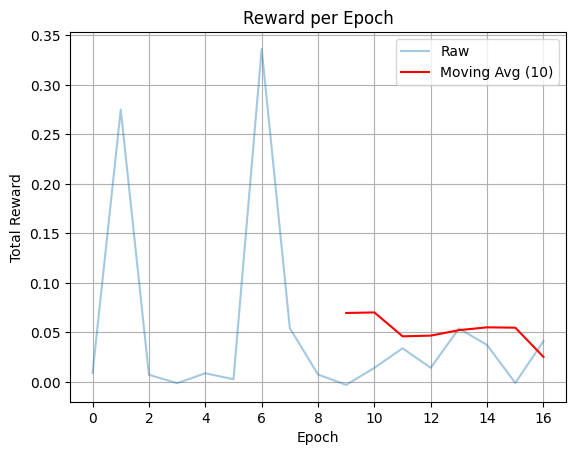

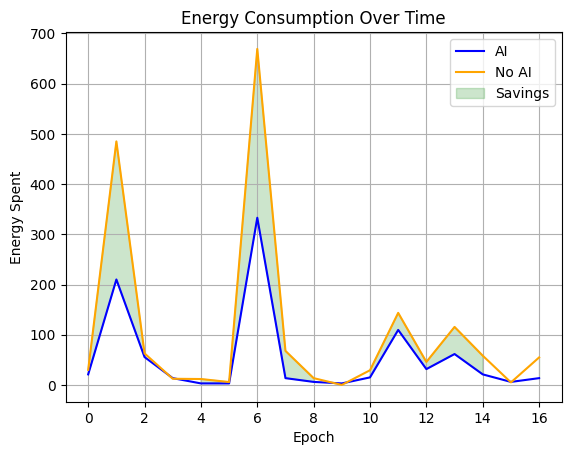

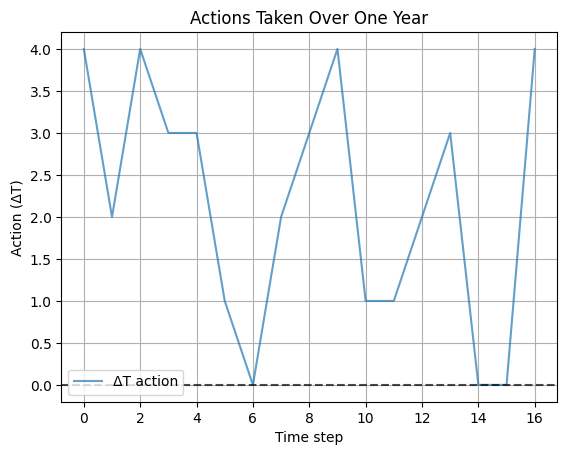

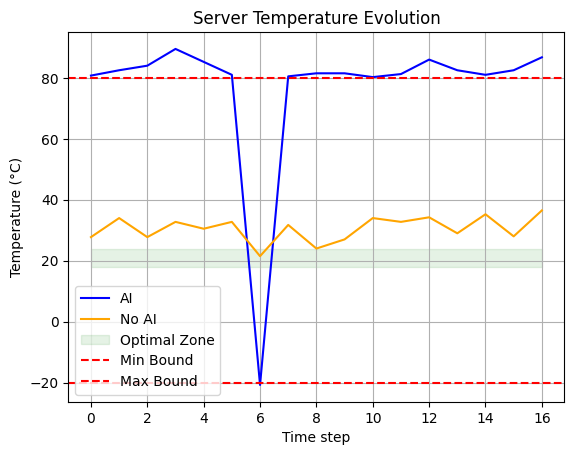

In [16]:
# ==== 2. PLOTTING RESULTS ====# 

# 1. Total Reward per Epoch
window = 10
smoothed = np.convolve(reward_history, np.ones(window)/window, mode="valid")
plt.figure()
plt.plot(reward_history, alpha=0.4, label="Raw")
plt.plot(range(window-1, len(reward_history)), smoothed, color="red", label=f"Moving Avg ({window})")
plt.xlabel("Epoch")
plt.ylabel("Total Reward")
plt.title("Reward per Epoch")
plt.legend()
plt.grid(True)
plt.show()

# 2. Energy Spent With and Without AI
plt.figure()
plt.plot(energy_ai_history, label="AI", color="blue")
plt.plot(energy_noai_history, label="No AI", color="orange")
plt.fill_between(range(len(energy_ai_history)),
                 energy_ai_history, energy_noai_history,
                 where=(np.array(energy_noai_history) > np.array(energy_ai_history)),
                 color="green", alpha=0.2, label="Savings")
plt.xlabel("Epoch")
plt.ylabel("Energy Spent")
plt.title("Energy Consumption Over Time")
plt.legend()
plt.grid(True)
plt.show()

# # 3. Percentage Energy Saved
# avg_saved = np.mean(percent_saved)
# plt.figure()
# plt.plot(percent_saved, label="% Saved")
# plt.axhline(y=0, color="red", linestyle="--")
# plt.axhline(y=avg_saved, color="green", linestyle="--", label=f"Avg: {avg_saved:.1f}%")
# plt.xlabel("Epoch")
# plt.ylabel("% Energy Saved")
# plt.title("Percentage Energy Saved with AI")
# plt.legend()
# plt.grid(True)
# plt.show()

# 4. Actions Over Time
plt.figure()
plt.plot(actions_log, alpha=0.7, label="ΔT action")
plt.axhline(y=0, color="black", linestyle="--", alpha=0.7)
plt.xlabel("Time step")
plt.ylabel("Action (ΔT)")
plt.title("Actions Taken Over One Year")
plt.legend()
plt.grid(True)
plt.show()

# 5. Temperature Evolution
plt.figure()
plt.plot(temperature_ai_log, label="AI", color="blue")
plt.plot(temperature_noai_log, label="No AI", color="orange")
# Optimal band
plt.fill_between(range(len(temperature_ai_log)),
                 env.optimal_temperature[0], env.optimal_temperature[1],
                 color="green", alpha=0.1, label="Optimal Zone")
# Boundaries
plt.axhline(y=env.min_temperature, color="red", linestyle="--", label="Min Bound")
plt.axhline(y=env.max_temperature, color="red", linestyle="--", label="Max Bound")
plt.xlabel("Time step")
plt.ylabel("Temperature (°C)")
plt.title("Server Temperature Evolution")
plt.legend()
plt.grid(True)
plt.show()



### Evaluación de la performance del modelo

In [17]:
print("Evaluating one year of energy management...")

# BUILDING THE ENVIRONMENT BY CREATING AN OBJECT OF THE ENVIRONMENT CLASS
env = Environment(
    optimal_temperature=(18.0, 24.0),
    initial_month=0,
    initial_number_users=20,
    initial_rate_data=30,
)

# LOAD PRE-TRAINED PYTORCH MODEL
model = Brain(number_actions)  # Initialize your model architecture
state_dict = torch.load("./Data/model.pth")  # Load the state dictionary
model.load_state_dict(state_dict)

# Set the model to evaluation mode
model.to(device).eval()

# CHOOSING THE MODE
train = False

# RUNNING 1 YEAR SIMULATION IN INFERENCE MODE
env.train = train
current_state, _, _ = env.observe()
current_state = (
    torch.tensor(current_state, dtype=torch.float).unsqueeze(0).to(device)
)  # Add batch dimension and move to device

# STARTING THE LOOP OVER 1 YEAR
for timestep in tqdm(range(12 * 30 * 24 * 60)):
    with torch.no_grad():  # Inference only, no gradients needed
        q_values = model(current_state)
    action = torch.argmax(q_values[0]).item()  # Get the action with the highest Q-value

    if action - direction_boundary < 0:
        direction = -1
    else:
        direction = 1
    energy_ai = abs(action - direction_boundary) * temperature_step

    # UPDATING ENVIRONMENT AND REACHING THE NEXT STATE
    next_state, _, _ = env.update_env(
        direction, energy_ai, int(timestep / (30 * 24 * 60))
    )  # month [0,11]
   

# PRINTING THE RESULTS FOR 1 YEAR
print(f"Total Energy spent with an AI: {env.total_energy_ai:.0f}")
print(f"Total Energy spent with no AI: {env.total_energy_noai:.0f}")
print(
    f"ENERGY SAVED WITH AI: {(env.total_energy_noai - env.total_energy_ai) / env.total_energy_noai * 100:.0f}%"
)

Evaluating one year of energy management...


  0%|          | 0/518400 [00:00<?, ?it/s]

100%|██████████| 518400/518400 [03:16<00:00, 2637.22it/s]

Total Energy spent with an AI: 3111044
Total Energy spent with no AI: 1970983
ENERGY SAVED WITH AI: -58%


### Resultados

El porcentaje de energía ahorrada varía en función de los experimentos. El porcentaje se determina simulando un ciclo anual completo. Ambos modelos pretenden mantener el servidor dentro de un rango de temperatura óptimo de 18° a 24°C. La simulación se realiza para pasos de tiempo de un minuto a lo largo de un año completo.

### Ejercicio

* **Mostrar un gráfico donde podamos ver la evolución de la energía en el tiempo tanto para la energía gastada con y sin AI.**

### Preguntas

**Conceptuales y Teóricas:**
* ¿Qué es el Deep Q-Learning y cómo se diferencia del Q-Learning tradicional?
* Explica el concepto de "replay memory" en Deep Q-Learning. ¿Por qué es importante?
* ¿Qué papel juega la función de pérdida (loss function) en el entrenamiento de una red Q en Deep Q-Learning?
* Describe cómo la técnica de "experience replay" mejora el proceso de aprendizaje en el Deep Q-Learning.
* ¿Qué es el "discount factor" en el contexto de Deep Q-Learning y cómo afecta al aprendizaje del agente?

**Sobre el Código y la Implementación:**
* En el código proporcionado para el problema de gestión energética, ¿cómo se determina la acción que debe tomar el agente en cada paso de tiempo?
* Describe cómo se actualiza el entorno después de que el agente toma una acción. ¿Qué información se utiliza para calcular el nuevo estado y la recompensa?
* Explica cómo se calcula la recompensa en este problema específico. ¿Qué incentivos y penalizaciones se consideran para el agente?
* ¿Cómo se maneja la exploración frente a la explotación en este problema de Deep Q-Learning?

**Aplicaciones y Análisis Crítico:**
* ¿Cuáles son las ventajas y desventajas de usar Deep Q-Learning en la gestión de la energía de un centro de datos?
* Considerando el problema de gestión energética, ¿qué modificaciones sugerirías para mejorar el rendimiento del modelo de Deep Q-Learning?
* Discute cómo cambiarías la arquitectura de la red neuronal para este problema específico y por qué.
* Analiza el impacto potencial de variar el tamaño del "replay memory" y el "batch size" en el rendimiento del aprendizaje.
* ¿Cómo podrías modificar el problema para hacerlo más complejo o realista? ¿Qué cambios en el modelo o el algoritmo serían necesarios?

### Adaptado de: 

* https://github.com/LaurentVeyssier/Minimize-Energy-consumption-with-Deep-Learning-model/tree/main

![Lenguaje Matemático](./Images/Matematicas.png)

![Contacto](./Images/Contacto.png)